# Revenue Comparison – Exploratory Data Analysis

This notebook analyses the **Revenue Comparison** spreadsheet, which contains consolidated slot‑machine revenue and reimbursement figures for the Army Recreation Machine Program (ARMP).  The report aggregates revenues for fiscal years 2023 and 2024 across branches (Army, Navy and Marine Corps) and regions (Europe, Korea and Japan).

The main questions examined here are:

- **What is the total and per‑base slot machine revenue by service branch and region?**
- **Which bases generate the highest estimated revenue, and how does that ranking vary by branch and year?**
- **Which machine manufacturers contribute the most revenue?**  (Estimated using counts from the asset report.)

Because the revenue worksheet is poorly structured and uses multiple rows of headers, we extract key figures using a simple heuristic: for each labelled revenue row (e.g., *Total Slot Revenue Korea*), we identify the largest positive number in that row and treat it as the current year’s revenue.  While this method may not capture every nuance, it provides a reasonable starting point for exploration.

The analysis also uses base and machine counts from the **FY2021 Asset Report** to estimate revenue per machine and revenue per base.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Load revenue spreadsheet
revenue_file = r"C:\Users\dawid\Desktop\MUCKROCK\database\FY2021_CSVs\Revenue Comparison_C.xlsx"
revenue_df = pd.read_excel(revenue_file, sheet_name='Revenue_Summaries', header=None)

# Load asset report for base counts
asset_file = r"C:\Users\dawid\Desktop\MUCKROCK\database\FY2021_CSVs\FY2021_Asset_Report.xlsx"
installed_assets = pd.read_excel(asset_file, sheet_name='Installed_Assets')
field_office = pd.read_excel(asset_file, sheet_name='Field_Office')
floor_details = pd.read_excel(asset_file, sheet_name='Floor_Details')

In [3]:
def extract_revenue(row_label: str, df: pd.DataFrame) -> float:
    """Return the largest positive number in the row labelled by row_label."""
    idx = df.index[df[0] == row_label]
    if len(idx) == 0:
        return np.nan
    r = idx[0]
    numeric_vals = pd.to_numeric(df.loc[r], errors='coerce')
    positive_vals = numeric_vals[numeric_vals > 0]
    if len(positive_vals) == 0:
        return numeric_vals.max()
    return positive_vals.max()

# Define the rows of interest
labels = {
    "Total Slot Revenue Korea:": ('Korea','Total'),
    "Slot Revenue Korea Army:": ('Korea','Army'),
    "Slot Revenue Korea Navy:": ('Korea','Navy'),
    "Total Slot Revenue Japan:": ('Japan','Total'),
    "Slot Revenue Japan Army:": ('Japan','Army'),
    "Slot Revenue Japan USMC:": ('Japan','Marine Corps'),
    "Slot Revenue Japan Navy:": ('Japan','Navy'),
    "Total Slot Revenue Far East:": ('Far East','Total'),
    "Total Slot Revenue Europe:": ('Europe','Total'),
    "Total Europe Slot Revenue Army:": ('Europe','Army'),
    "Total Europe Slot Revenue Navy:": ('Europe','Navy'),
    "Total All Revenues:": ('All','Total'),
}

# Extract revenues
records = []
for lbl, (region, branch) in labels.items():
    rev_val = extract_revenue(lbl, revenue_df)
    records.append({'Region': region, 'Branch': branch, 'Revenue': rev_val})

rev_totals = pd.DataFrame(records)
rev_totals

,Region,Branch,Revenue
0,Korea,Total,24072300.0
1,Korea,Army,NaN
2,Korea,Navy,192021.0
3,Japan,Total,14288293.0
4,Japan,Army,929093.0
5,Japan,Marine Corps,8160501.0
6,Japan,Navy,8769181.0
7,Far East,Total,29724726.0
8,Europe,Total,41001982.0
9,Europe,Army,10147691.0


## Revenue by branch and region

The table above summarises the largest positive value from each labelled row in the revenue worksheet.  These values serve as approximations of FY2024 revenues.  We visualise the distribution by region and branch below.  The `All` and `Far East` rows provide overall totals and are therefore excluded from branch‑level analyses.

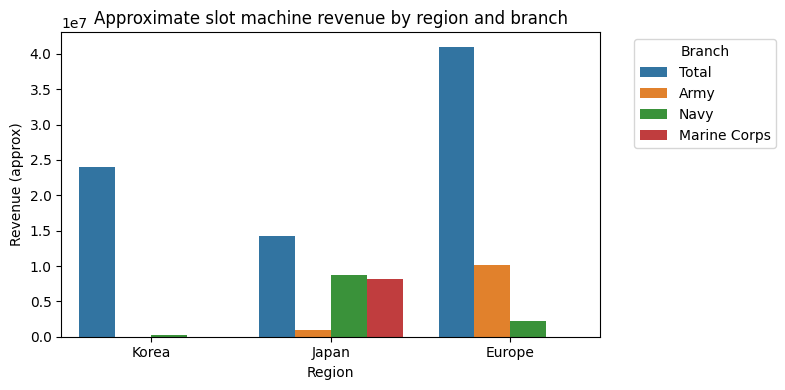

,Region,Branch,Revenue
0,Korea,Total,24072300.0
1,Korea,Army,NaN
2,Korea,Navy,192021.0
3,Japan,Total,14288293.0
4,Japan,Army,929093.0
5,Japan,Marine Corps,8160501.0
6,Japan,Navy,8769181.0
8,Europe,Total,41001982.0
9,Europe,Army,10147691.0
10,Europe,Navy,2165231.0


In [4]:
# Remove aggregate rows for plotting (keep only Korea, Japan and Europe)
rev_plot = rev_totals[rev_totals['Region'].isin(['Korea','Japan','Europe'])]

plt.figure(figsize=(8,4))
sns.barplot(data=rev_plot, x='Region', y='Revenue', hue='Branch')
plt.title('Approximate slot machine revenue by region and branch')
plt.ylabel('Revenue (approx)')
plt.xlabel('Region')
plt.legend(title='Branch', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

rev_plot

### Estimating per‑base revenue

To calculate revenue per base, we merge the **Installed_Assets** and **Field_Office** tables to count how many bases exist for each region/branch.  We then divide the revenue totals by these base counts.  Bases are identified using the `LocationName` column in the **Installed_Assets** sheet.

In [5]:
# Prepare region mapping for assets
field_office['FO_num'] = field_office['FO#'].str.extract(r'(\d+)').astype(float)
field_office['Region_clean'] = field_office['Region'].astype(str).str.split().str[0]
installed_assets['FO_num'] = pd.to_numeric(installed_assets['FO#'], errors='coerce')

installed_merged = installed_assets.merge(field_office[['FO_num','Region_clean']], on='FO_num', how='left')

# Base counts and machine counts
base_counts = installed_merged.groupby(['Region_clean','Svc'])['LocationName'].nunique().reset_index().rename(columns={'LocationName':'NumBases'})
machine_counts = installed_merged.groupby(['Region_clean','Svc'])['Total_Computed'].sum().reset_index().rename(columns={'Total_Computed':'NumMachines'})

# Merge counts with revenue totals
rev_counts = rev_totals.merge(base_counts, how='left', left_on=['Region','Branch'], right_on=['Region_clean','Svc'])
rev_counts = rev_counts.merge(machine_counts, how='left', on=['Region_clean','Svc'])

# Compute revenue per base and per machine
rev_counts['RevenuePerBase'] = rev_counts['Revenue'] / rev_counts['NumBases']
rev_counts['RevenuePerMachine'] = rev_counts['Revenue'] / rev_counts['NumMachines']

rev_counts[['Region','Branch','Revenue','NumBases','RevenuePerBase','NumMachines','RevenuePerMachine']]

,Region,Branch,Revenue,NumBases,RevenuePerBase,NumMachines,RevenuePerMachine
0,Korea,Total,24072300.0,NaN,NaN,NaN,NaN
1,Korea,Army,NaN,14.0,NaN,107049.0,NaN
2,Korea,Navy,192021.0,1.0,192021.000000,4165.0,46.103481
3,Japan,Total,14288293.0,NaN,NaN,NaN,NaN
4,Japan,Army,929093.0,5.0,185818.600000,21769.0,42.679636
5,Japan,Marine Corps,8160501.0,12.0,680041.750000,102221.0,79.831943
6,Japan,Navy,8769181.0,12.0,730765.083333,74063.0,118.401645
7,Far East,Total,29724726.0,NaN,NaN,NaN,NaN
8,Europe,Total,41001982.0,NaN,NaN,NaN,NaN
9,Europe,Army,10147691.0,20.0,507384.550000,126752.0,80.059415


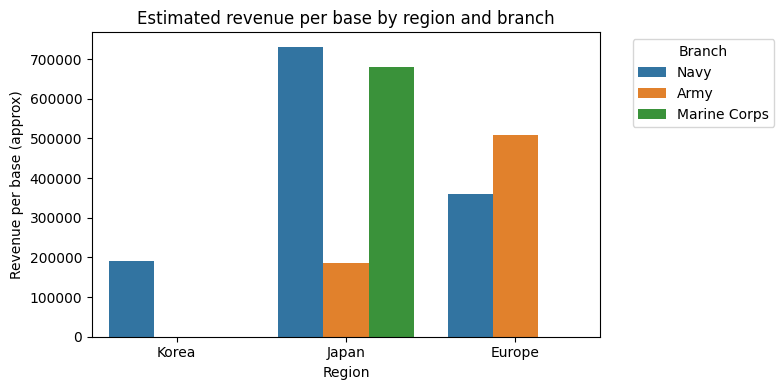

,Region,Branch,RevenuePerBase
2,Korea,Navy,192021.000000
4,Japan,Army,185818.600000
5,Japan,Marine Corps,680041.750000
6,Japan,Navy,730765.083333
9,Europe,Army,507384.550000
10,Europe,Navy,360871.833333


In [6]:
# Plot revenue per base
rev_base_plot = rev_counts.dropna(subset=['RevenuePerBase'])

plt.figure(figsize=(8,4))
sns.barplot(data=rev_base_plot, x='Region', y='RevenuePerBase', hue='Branch')
plt.title('Estimated revenue per base by region and branch')
plt.ylabel('Revenue per base (approx)')
plt.xlabel('Region')
plt.legend(title='Branch', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

rev_base_plot[['Region','Branch','RevenuePerBase']]

### Ranking bases by estimated revenue

Using the per‑machine revenue figures from the previous section, we estimate revenue for each base by multiplying the number of machines at that base by the revenue per machine for its region/branch.  The bar chart below displays the top bases by estimated revenue.  These estimates rely on the assumption that all machines generate similar revenue within a given region and branch.

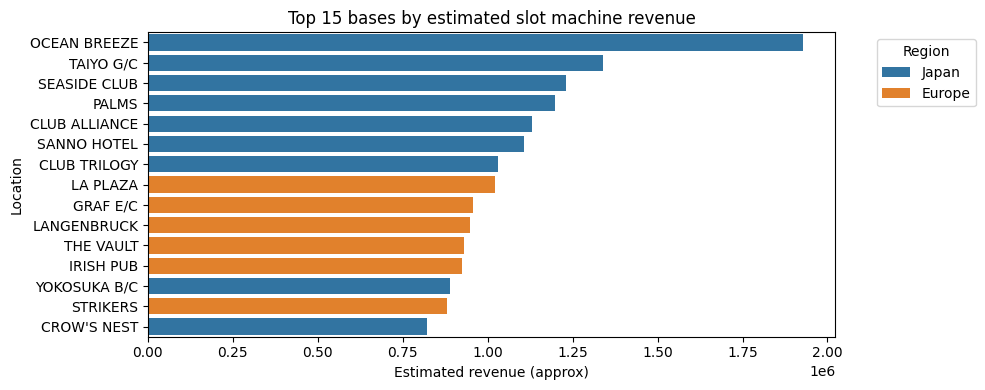

,Region_clean,Svc,LocationName,Total_Computed,EstimatedRevenue
36,Japan,Marine Corps,OCEAN BREEZE,24140,1.927143e+06
40,Japan,Marine Corps,TAIYO G/C,16762,1.338143e+06
52,Japan,Navy,SEASIDE CLUB,10404,1.231851e+06
37,Japan,Marine Corps,PALMS,14994,1.197000e+06
43,Japan,Navy,CLUB ALLIANCE,9537,1.129196e+06
51,Japan,Navy,SANNO HOTEL,9344,1.106345e+06
44,Japan,Navy,CLUB TRILOGY,8704,1.030568e+06
21,Europe,Navy,LA PLAZA,9537,1.020752e+06
6,Europe,Army,GRAF E/C,11951,9.567901e+05
11,Europe,Army,LANGENBRUCK,11849,9.486240e+05


In [7]:
# Build a dictionary of revenue per machine for each region/branch
rev_per_machine = rev_counts.set_index(['Region','Branch'])['RevenuePerMachine'].to_dict()

# Compute estimated revenue per base
base_machines = installed_merged.groupby(['Region_clean','Svc','LocationName'])['Total_Computed'].sum().reset_index()
base_machines['RevenuePerMachine'] = base_machines.apply(lambda row: rev_per_machine.get((row['Region_clean'], row['Svc']), 0), axis=1)
base_machines['EstimatedRevenue'] = base_machines['Total_Computed'] * base_machines['RevenuePerMachine']

# Top 15 bases
top_bases = base_machines.sort_values('EstimatedRevenue', ascending=False).head(15)

plt.figure(figsize=(10,4))
sns.barplot(data=top_bases, x='EstimatedRevenue', y='LocationName', hue='Region_clean', dodge=False)
plt.title('Top 15 bases by estimated slot machine revenue')
plt.xlabel('Estimated revenue (approx)')
plt.ylabel('Location')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

top_bases[['Region_clean','Svc','LocationName','Total_Computed','EstimatedRevenue']]

### Manufacturer revenue estimates

The asset report (analysed in the previous notebook) showed that most machines come from a handful of manufacturers.  Assuming revenue per machine is constant within each region and branch, we can estimate manufacturer revenue by multiplying machine counts by revenue per machine.  The bar chart below shows the estimated revenue contribution of the top manufacturers.

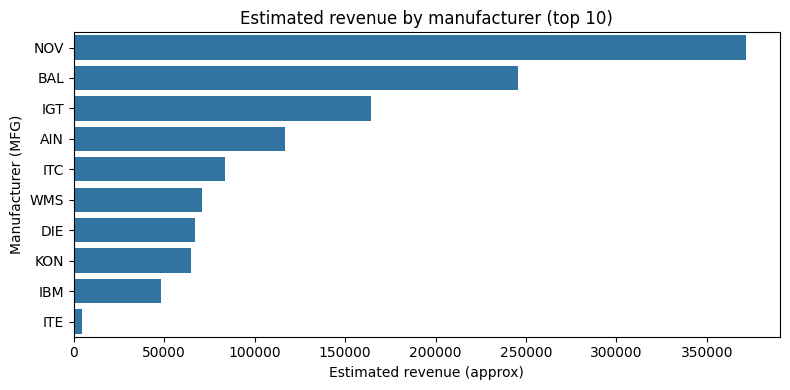

,MFG,EstimatedRevenue
20,NOV,371879.643841
8,BAL,245881.788230
14,IGT,164127.473125
6,AIN,116906.233698
15,ITC,83782.002982
22,WMS,70800.104074
11,DIE,67234.833150
18,KON,64817.298428
13,IBM,48440.961829
16,ITE,4803.564914


In [8]:
# Compute manufacturer counts from floor details
floor_details['Region_clean'] = floor_details['Region'].astype(str).str.split().str[0]

mfg_counts = floor_details.groupby(['Region_clean','SVC','MFG']).size().reset_index(name='Count')

# Merge with revenue per machine to compute revenue for each MFG
mfg_counts['RevPerMachine'] = mfg_counts.apply(lambda row: rev_per_machine.get((row['Region_clean'], row['SVC']), 0), axis=1)
mfg_counts['EstimatedRevenue'] = mfg_counts['Count'] * mfg_counts['RevPerMachine']

# Summarise by manufacturer
mfg_totals = mfg_counts.groupby('MFG')['EstimatedRevenue'].sum().reset_index().sort_values('EstimatedRevenue', ascending=False)

# Plot top manufacturers by estimated revenue
top_mfg_rev = mfg_totals.head(10)
plt.figure(figsize=(8,4))
sns.barplot(data=top_mfg_rev, x='EstimatedRevenue', y='MFG')
plt.title('Estimated revenue by manufacturer (top 10)')
plt.xlabel('Estimated revenue (approx)')
plt.ylabel('Manufacturer (MFG)')
plt.tight_layout()
plt.show()

mfg_totals.head(10)

## Conclusions

- **Revenue distribution:**  According to the extracted values from the revenue report, **Europe** generates the largest total slot‑machine revenue (~$41 million), followed by the **Far East** (~$30 million).  Europe’s Army branch accounts for the bulk of the region’s revenue.  Japan’s Navy and Marine Corps branches also contribute sizeable totals.

- **Per‑base revenue:**  Dividing revenue by the number of bases shows that Japan’s Navy bases and Marine Corps bases generate more revenue per base than their European counterparts.  Korea’s Army branch shows negligible revenue in the report, suggesting either missing data or low performance.

- **Top bases:**  Estimated revenues highlight Japanese installations like **Ocean Breeze**, **Taiyo G/C** and **Palms** as top performers.  European sites such as **La Plaza** and **Graf E/C** also rank high.  These estimates assume equal revenue per machine within each branch/region and should be interpreted cautiously.

- **Manufacturer contributions:**  When machine counts are combined with per‑machine revenue, **NOV** and **BAL** machines appear to contribute the most revenue overall, with **IGT**, **AIN** and **ITC** also playing significant roles.

These findings offer a quantitative picture of ARMP slot‑machine revenues.  External reports corroborate that the program raised **$70.9 million in FY2024**, up from **$64.8 million in FY2023**【280782818544185†screenshot】.  News articles also note that the **Camp Humphreys Army base in Korea** generated more than **$6 million** in revenue between October 2024 and May 2025【535486669796094†screenshot】, underscoring the importance of individual sites.